In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import dlib
from imutils import face_utils
import hpe
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from glob import glob
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import cv2
import time
import mediapipe
import natsort
import math
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## First of Download the Model Files and Dataset Samples from following Link
https://drive.google.com/file/d/17ZlD-qDmUly5mHB4r7ebrK_EsOCB8WLa/view?usp=drive_link

In [2]:

# # Load Model 256
model_U = torch.load(
    "/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Experiments/U2net/U2NET_MULTICLASS_IMG_256_DIC_batch_8/Miche_model_2023_04_11_22:14:26_val_iou0.900.pt", map_location=device)

model_U.eval()


U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

# GT For Columbian Dataset

In [3]:
def distanceFromOriginToAngle(img_name):
    
    distanceBetweenAngle = [21.87,44.08,66.99]
    
    angleRange = 5
    
    angleAmount = abs(float(img_name.split(".")[0].split("_")[-1][:-1]))
    
    if angleAmount == 0.0 :
        return 0
    else:
        
        if angleAmount == 5.0:
            return distanceBetweenAngle[0]
        elif angleAmount ==10.0:
            return distanceBetweenAngle[1]
        else:
            return distanceBetweenAngle[2]

In [4]:
def calculateEyeCorners(shape_array):

    dMid = [abs((shape_array[133][0]+shape_array[362][0])//2),abs((shape_array[133][1]+shape_array[362][1])//2)]
    
    dMidLeft = [abs((shape_array[133][0]+shape_array[33][0])//2),abs((shape_array[133][1]+shape_array[33][1])//2)]
    
    dMidRight = [abs((shape_array[362][0]+shape_array[263][0])//2),abs((shape_array[362][1]+shape_array[263][1])//2)]
    
    
    
    
    return dMid, dMidLeft, dMidRight

In [5]:

def findMinEyeX(cntour):
    
    minVal = cntour[0][0][0]
    for i in cntour:
        if i[0][0] < minVal:
            minVal = i[0][0]

    return minVal

In [6]:
def drawContours(frame, pred_mask, h, w, margin):
    """Draw Iris and Pupil Contours on Original Image

    Args:
        frame (_numpy_): _original image frame_
        pred_mask (_torch.float32_): _prediction from model_
        h (_int_): _cropped eye image height_
        w (_int_): _cropped eye image height_
        margin (_dic_): _Eye Top Left x and y coordinates


    """

    pred_image = decode_segmap(pred_mask) * 255
    pred_image = pred_image.astype(np.uint8)
    edge_detected_image = cv2.Canny(pred_image, 0, 200)

    contours, hierarchy = cv2.findContours(
        edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    max_area = {}

    for contour in contours:

        approx = cv2.approxPolyDP(
            contour, 0.01*cv2.arcLength(contour, True), True)
        area = cv2.contourArea(contour)
        # print(area)
        if ((len(approx) > 8) & (len(approx) < 23) & (area > 30)):
            findRadiusIris(pred_mask, eye_w, eye_h, ori_cx, ori_cy, margin)

            max_area[area] = contour

    x = sorted(max_area, key=lambda x: x)

    print(x)
    max_contour = max_area[x[-1]]
    min_contour = max_area[x[1]]

    for coords in min_contour:

        coords[0][0] = margin["top_left"][0] + ((coords[0][0]/RESIZE_AMT) * w)
        coords[0][1] = margin["top_left"][1] + ((coords[0][1]/RESIZE_AMT) * h)

    for coords in max_contour:

        coords[0][0] = margin["top_left"][0] + ((coords[0][0]/RESIZE_AMT) * w)
        coords[0][1] = margin["top_left"][1] + ((coords[0][1]/RESIZE_AMT) * h)

    cv2.drawContours(frame, [max_contour], 0, (0, 0, 255), 1)
    cv2.drawContours(frame, [min_contour], 0, (0, 255, 0), 1)

    return frame


In [7]:

def decode_segmap(temp, n_classes=3):

    colors = [[0,   0,   0], [0, 255, 0], [0, 0, 255]]
    label_colours = dict(zip(range(n_classes), colors))
    # convert gray scale to color
    temp = temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb


In [8]:
def predict_image_masku2net(model, image):

    image = imgTransform(image[:, :, ::-1], resize_amt=RESIZE_AMT_SEGMENTATION,
                         mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

    image = image.to(device)

    with torch.no_grad():

        softmax = nn.Softmax(dim=1)
        image = image.unsqueeze(0)

        model_output, _, _, _, _, _, _ = model(image)
        output = softmax(model_output)

        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked


In [9]:
def cropped_image(img, shape_array, padded_amt=15, enhance=True):
    """Cropped eye region and enhance it according to the requirement

    Args:
        img (__numpy__): _Original Image_
        shape_array (_numpy_): _FaceLandMark locations_findRadiusIris(pred_mask,eye_w,eye_h,ori_cx,ori_cy,margin)
        padded_amt (int, optional): _padding size_. Defaults to 20.
        enhance (bool, optional): _applying SISR_. Defaults to True.
    """

    Leye = {"top_left": shape_array[70], "bottom_right": shape_array[133]}

    Reye = {"top_left": shape_array[285],
            "bottom_right": shape_array[263]}

    left_eye = img[Leye["top_left"][1]:Leye["bottom_right"][1] +
                   50, Leye["top_left"][0]+40:Leye["bottom_right"][0]]

    right_eye = img[Reye["top_left"][1]:Reye["bottom_right"][1] +
                    60, Reye["top_left"][0]:Reye["bottom_right"][0]]

    Leye["top_left"][0] += 40

    if enhance:
        left_eye, _ = GAN_MODEL.enhance(left_eye)
        right_eye, _ = GAN_MODEL.enhance(right_eye)

    return left_eye, right_eye, Leye, Reye


In [10]:
def calculateParameters(shape_array):
    """Return meanWidth,piyotY and SymmX along with Radius of the face

    Args:
        shape_array (_numpy_): _FaceLandMark locations_
    """

    meanWidth = shape_array[356][0] - shape_array[127][0]

    symmAxis_x = findSymX(shape_arr=shape_array)

    piyot_y = shape_array[4][1]

    return meanWidth, symmAxis_x, piyot_y, meanWidth/2


In [11]:
def findSymX(shape_arr):
    """Return average symmetric axis x coordinate

    Args:
        shape_arr (_np.numpy_): _FaceLandMark Coordinates_

    Returns:
        _float32_: _x coordinate of symmetric x axis_
    """
    x_cord = []
    coordinates_of_symmetric = [9, 8,
                                168,
                                6,
                                197,
                                195,
                                5,
                                4,
                                1,
                                19,
                                94,
                                2,
                                164,
                                0,
                                11,
                                12,
                                13,
                                14,
                                15, 16, 17, 18]

    for num in coordinates_of_symmetric:
        x_cord.append(shape_arr[num][0])

    return sum(x_cord)/len(x_cord)


In [12]:
def gettingRotation(innerEyeX,innerEyey,outerEyex,outerEyey,symmAxis_x,piyot_y,radiusEyeBall,irisCenterX,irisCentery,theta,phi,R):
    """Getting Rotation of Iris Center

    Args:
        innerEyeX (_float_): _Inner Eye X coordinate_
        innerEyey (_float_): _Inner Eye Y coordinate_
        outerEyex (_float_): _Outer Eye X coordinate_
        outerEyey (_flaot_): _Outer Eye Y coordinate_
        symmAxis_x (_float_): _Symmetric axis of the Face_
        piyot_y (_flaot_): _piyot y_
        radiusEyeBall (_flaot_): _radius of Eye Ball-->(12.2)/5.9 * Radius of Iris_
        irisCenterX (_float_): _Center of Iris X_
        irisCentery (_float_): _Center of Iris Y_
        theta (_float_): _HeadPose Theta angle in radians _
        phi (_float_): _HeadPose Phi angle in Phi_
        R (_float_): _MeanWidth/2_

    Returns:
        _list_: _Rotated x & y angle of Iris Center_
    """
    
    irisRot_x = irisX(innerEyeCorner_x=innerEyeX, outerEyeCorner_x=outerEyex,
                            symmAxis_x=symmAxis_x, r=radiusEyeBall, R=R, iris_x=irisCenterX, theta=theta)
    
    
    irisRot_y = irisY(innerEyeCorner_y=innerEyey, outerEyeCorner_y=outerEyey,
                            pivot_y=piyot_y, r=radiusEyeBall, iris_y=irisCentery, phi=phi)
    
    return [irisRot_x,irisRot_y]

In [13]:
def innerEyeCornerRotation(symmAxis_x,piyot_y,R,theta,phi,eyeCornerArray):
    """Calculate rotation for eye corner

    Args:
        shape_array (_np.array_): _Landmarks Location of the Face_
        symmAxis_x (_list_): _Symmetric axis of the Face_
        piyot_y (_list_): _piyot Y_
        R (_int_): _meanWidth/2_
        theta (_float_): _Theta in Radians_
        phi (_float_): _Phi in Radians_
        eyeCornerArray (_array_): _Eye corners in the Initialization pase_

    Returns:
        _type_: _Rotated Inner Corner for Both Eyes_
    """
    
    
    
    innerEyeCorner_right_x, innerEyeCorner_right_y, outerEyeCorner_right_x, outerEyeCorner_right_y, innerEyeCorner_left_x, innerEyeCorner_left_y, outerEyeCorner_left_x, outerEyeCorner_left_y=eyeCornerArray

    
    # The rotated x & y coordinate of right inner Eye Corner
    innerEyeCornerRot_right_x = cornerX(innerEyeCorner_x=innerEyeCorner_right_x, symmAxis_x=symmAxis_x, R=R, theta=theta)
    innerEyeCornerRot_right_y = cornerY(innerEyeCorner_y=innerEyeCorner_right_y, pivot_y=piyot_y, phi=phi)

    
    # The rotated x & y coordinate of left inner Eye Corner
    innerEyeCornerRot_left_x = cornerX(innerEyeCorner_x=innerEyeCorner_left_x, symmAxis_x=symmAxis_x, R=R, theta=theta)
    innerEyeCornerRot_left_y = cornerY(innerEyeCorner_y=innerEyeCorner_left_y, pivot_y=piyot_y, phi=phi)
    
    
    return [innerEyeCornerRot_right_x,innerEyeCornerRot_right_y,innerEyeCornerRot_left_x,innerEyeCornerRot_left_y]
    


In [14]:
def eyeGazeDirectionLeft(currentIrisCenterX, currentIrisCenterY,innerEyecornerX,innerEyecornerY,irisRotX,irisRotY,innerEyeCornerRotX,innerEyeCornerRotY,radiusEyeBall,theta,phi):
    
    delta_x_new = currentIrisCenterX - innerEyecornerX  
    delta_y_new = innerEyecornerY - currentIrisCenterY
    
    delta_x0 = irisRotX - innerEyeCornerRotX
    delta_y0 = innerEyeCornerRotY - irisRotY
    
    delta_x = delta_x_new  - (delta_x0 - (radiusEyeBall * math.sin(theta)))
    delta_y = delta_y_new - (delta_y0 - (radiusEyeBall * math.sin(phi)))
    
    alpha = math.asin(delta_x  / radiusEyeBall) 
    beta = math.asin(delta_y  / radiusEyeBall) 
    
    
    return alpha,beta
    

In [15]:
def eyeGazeDirectionRight(currentIrisCenterX, currentIrisCenterY,innerEyecornerX,innerEyecornerY,irisRotX,irisRotY,innerEyeCornerRotX,innerEyeCornerRotY,radiusEyeBall,theta,phi):
    
    delta_x_new = innerEyecornerX - currentIrisCenterX
    delta_y_new = innerEyecornerY - currentIrisCenterY
    
    delta_x0 = innerEyeCornerRotX - irisRotX
    delta_y0 = innerEyeCornerRotY - irisRotY
    
    delta_x = delta_x0 + (radiusEyeBall * math.sin(theta)) - delta_x_new 
    delta_y = delta_y_new - (delta_y0 - (radiusEyeBall * math.sin(phi)))
    
    alpha = math.asin(delta_x  / radiusEyeBall)
    beta = math.asin(delta_y  / radiusEyeBall)
    
    
    return alpha,beta
    


In [16]:

def findRadiusIrisImageMoments(pred_mask, eye_w, eye_h,margin):

    pred_image = decode_segmap(pred_mask) * 255
    pred_image = pred_image.astype(np.uint8)
    edge_detected_image = cv2.Canny(pred_image, 0, 200)


    plt.imshow(edge_detected_image)
    plt.show()
    contours, hierarchy = cv2.findContours(
        edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    
    area_dic = {}
    for cnt in contours:
        
        area  = cv2.contourArea(cnt)
        
        
        if area >30:
        
        
            area_dic[area] = cnt
        
    
    sorted_area = sorted(area_dic)
    
    pupil = area_dic[sorted_area[1]]
    
    
    # print(pupil
    
    
    # print(type(pupil))
    # print(type(min(contours, key=cv2.contourArea)))
    
    # print(sorted_area)
    # finding contour with #maximum area
    # pupil = min(contours, key=cv2.contourArea)
    M = cv2.moments(pupil)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    ori_cx = int(margin["top_left"][0] +((cx/RESIZE_AMT_SEGMENTATION ) * eye_w))
    ori_cy = int(margin["top_left"][1] + ((cy/RESIZE_AMT_SEGMENTATION) * eye_h))

    # print(ori_cx,ori_cy)

    iris = area_dic[sorted_area[-1]]
    # iris = max(contours, key=cv2.contourArea)
    minValOfIris = findMinEyeX(iris)

    minValOfIris = margin["top_left"][0] + \
        ((minValOfIris/RESIZE_AMT_SEGMENTATION) * eye_w)

    radius_of_iris = ori_cx-minValOfIris

    eyeBallRadius = (12.2/5.9) * radius_of_iris

    return eyeBallRadius, ori_cx, ori_cy, radius_of_iris


In [17]:

def findRadiusIrisByRegression(pred_mask, eye_w, eye_h, ori_cx, ori_cy, margin):

    pred_image = decode_segmap(pred_mask) * 255
    pred_image = pred_image.astype(np.uint8)
    edge_detected_image = cv2.Canny(pred_image, 0, 200)

    # plt.imshow(edge_detected_image)
    # plt.show()

    contours, hierarchy = cv2.findContours(
        edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # finding contour with #maximum area
    iris = max(contours, key=cv2.contourArea)

    minValOfIris = findMinEyeX(iris)

    minValOfIris = margin["top_left"][0] + \
        ((minValOfIris/RESIZE_AMT_SEGMENTATION) * eye_w)

    radius_of_iris = ori_cx-minValOfIris

    eyeBallRadius = (12.2/5.9) * radius_of_iris

    return eyeBallRadius, ori_cx, ori_cy, radius_of_iris


In [18]:


def calCThetaAngle(img_name,shape_arr):
    
    pixelPerMM = 5.9/116
    
    adjacentDistance = 250
    
    distance = distanceFromOriginToAngle(img_name)
    
    dmid, dmidLeft, dmidRight = calculateEyeCorners(shape_arr)

    dLeft = ((dmid[0]-dmidLeft[0]) * pixelPerMM)/10

    dRight = ((dmidRight[0] - dmid[0]) * pixelPerMM)/10

    angleAmount = float(img_name.split(".")[0].split("_")[-1][:-1])

    left_opposite = 0
    right_opposite = 0

    if angleAmount < 0:

        left_opposite = distance - dLeft
        right_opposite = distance + dRight

    elif angleAmount > 0:
        left_opposite = distance + dLeft
        right_opposite = distance - dRight

    else:
        left_opposite = dLeft
        right_opposite = dRight

    left_theta = np.degrees(np.arctan(left_opposite/adjacentDistance))
    right_theta = np.degrees(np.arctan(right_opposite/adjacentDistance))

    return left_theta, right_theta


In [19]:

def irisX(innerEyeCorner_x, outerEyeCorner_x, symmAxis_x, r, R, iris_x, theta):

    # Calculate the centre point of the eyeball with respect to the symmetry axis of the face
    eyeMid_x = ((innerEyeCorner_x + outerEyeCorner_x) / 2) - symmAxis_x
    eyeMid_y = r - R

    # Calculate the radius, Re
    Re = math.sqrt(eyeMid_x ** 2 + eyeMid_y ** 2)

    # Calculate the angle, omega_h
    wh = math.asin(eyeMid_x / Re)

    # Calculate the angle, omega_e
    we = math.asin(((iris_x - symmAxis_x) - eyeMid_x) / r)

    # Calculate the new centre point of the eyeball with respect to the symmetry axis of the
    # face, after a head rotation by the yaw angle, theta
    eyeMidRot_x = Re * math.sin(wh + theta)

    # Calculate the new image position of the iris centre after rotating by the head yaw angle
    irisRot_x = (r * math.sin(we + theta)) + eyeMidRot_x

    return irisRot_x


# Compute the rotated iris centre y-coordinate, for each eye
def irisY(innerEyeCorner_y, outerEyeCorner_y, pivot_y, r, iris_y, phi):

    # Calculate the centre point of the eyeball with respect to a pivot point
    eyeMid_y = ((innerEyeCorner_y + outerEyeCorner_y) / 2) - pivot_y

    # print((eyeMid_y - (iris_y - pivot_y)) / r)
    we = math.asin((eyeMid_y - (iris_y - pivot_y)) / r)

    # Calculate the new image position of the iris centre after rotating by the head pitch angle
    irisRot_y = (eyeMid_y * math.cos(phi)) - (r * math.sin(we + phi))

    return irisRot_y


# Compute the rotated inner eye corner x-coordinate, for each eye
def cornerX(innerEyeCorner_x, symmAxis_x, R, theta):

    # Calculate the eye corner position with respect to the symmetry axis of the face
    x = innerEyeCorner_x - symmAxis_x

    # Calculate the angle between the eye corner and the symmetry axis of the face
    wc = math.asin(x / R)

    # Calculate the new image position of the eye corner after rotating by the head yaw angle
    innerEyeCornerRot_x = R * math.sin(wc + theta)

    return innerEyeCornerRot_x


# Compute the rotated inner eye corner y-coordinate, for each eye
def cornerY(innerEyeCorner_y, pivot_y, phi):

    # Calculate the eye corner position with respect to a pivot point
    y = innerEyeCorner_y - pivot_y

    # Calculate the new image position of the eye corner after rotating by the head pitch angle
    innerEyeCornerRot_y = y * math.cos(phi)

    return innerEyeCornerRot_y


In [20]:
def regressionPrediction(model, image, mean, std):

    # val_transforms =  A.Compose([
    #                                 A.Resize(width=RESIZE_AMT,height=RESIZE_AMT),
    #                                 A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    #                                 ToTensorV2(p=1)
    #                                 ])

    unnorm = UnNormalize(mean=mean, std=std)

    # img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    # print()

    img = imgTransform(
        image=image[:, :, ::-1], resize_amt=RESIZE_AMT_REGRESSION, mean=mean, std=std)

    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        out_coord = model(img)

    img = img.squeeze(0)

    img = transforms.ToPILImage()(unnorm(img))

    pred_coord = out_coord.detach().cpu().numpy()[0]

    return rescale_coordinate(pred_coord, image, RESIZE_AMT_REGRESSION)


In [21]:
def imgTransform(image,resize_amt,mean,std):
    """ Transform numpy images to Torch tensors

    Args:
        image (_numpy_): _cropped_eye_region_
        resize_amt (_int_): _Input Resize for the image_

    Returns:
        _torch.float32_: _Transformed image tensor_
    """

    
    
    # segmentation
    # mean =(0.5, 0.5, 0.5) std =(0.5, 0.5, 0.5)
    
    transform = A.Compose([
        A.Resize(resize_amt, resize_amt),
        A.augmentations.transforms.Normalize(
            mean=mean, std=std),
        ToTensorV2()
    ])
    
   
    return transform(image=image)["image"]

In [22]:
def captureFaceLandmarks(frame):

    results = face_mesh.process(frame)
    
    if results.multi_face_landmarks is not None:
        landmarks = results.multi_face_landmarks[0]

        shape_arr = []

        for landmark in landmarks.landmark:

            x = landmark.x
            y = landmark.y

            relative_x = int(x * frame.shape[1])
            relative_y = int(y * frame.shape[0])

            shape_arr.append([relative_x, relative_y])

        return np.array(shape_arr)
    else:
        return []

In [23]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.[float(angle[:-1]) for angle in x.split(".")[0].split("_")[2:]]
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [24]:
def rescale_coordinate(coord, original_image, resize_amt):

    h, w = original_image.shape[:2]
    coord[0] = int((coord[0]/resize_amt) * w)
    coord[1] = int((coord[1]/resize_amt) * h)

    return coord

In [25]:
def load_model(model_path):
    """Load Regression model

    Args:
        model_path (_str_): _model path_


    Returns:
        _torch model_: _RESNET model_
    """

    model = torch.load(model_path, map_location=device)

    model.eval()

    return model

In [26]:
def innerOuterCornerofEye(shape_array):

    # Inner Iris X and Y coordinate of Right eyeprint(f"Right Eye shape:- {right_eye.shape}")
    # print(f"Left Eye shape:- {left_eye.shape}")
    innerEyeCorner_right_x = shape_array[362][0]
    innerEyeCorner_right_y = shape_array[362][1]

    # Outer Iris X and Y coordinate of Right eye
    outerEyeCorner_right_x = shape_array[263][0]
    outerEyeCorner_right_y = shape_array[263][1]

    # Inner Iris X and Y coordinate of Left eye
    innerEyeCorner_left_x = shape_array[133][0]
    innerEyeCorner_left_y = shape_array[133][1]

    # Outer Iris X and Y coordinate of Left eye
    outerEyeCorner_left_x = shape_array[33][0]
    outerEyeCorner_left_y = shape_array[33][1]

    return innerEyeCorner_right_x, innerEyeCorner_right_y, outerEyeCorner_right_x, outerEyeCorner_right_y, innerEyeCorner_left_x, innerEyeCorner_left_y, outerEyeCorner_left_x, outerEyeCorner_left_y


In [27]:
def scaleCoorinatesToOriginalImage(pred_coords, eye_margin):

    # {'top_left': array([385, 214]), 'bottom_right': array([426, 226])}

    x1 = eye_margin["top_left"][0] + pred_coords[0]
    y1 = eye_margin["top_left"][1] + pred_coords[1]

    return [x1, y1]


In [28]:
def initialization_function(frame, frameCounter, visualize=True, enhance=False):

    # MediaPipe
    shape_array = captureFaceLandmarks(frame)

    meanWidth, symmAxis_x, piyot_y, R = calculateParameters(shape_array)

    left_eye, right_eye, Leye, Reye = cropped_image(
        frame, shape_array, enhance=False)

    # pred_c_leye = regressionPrediction(REGRESSION_MODEL, left_eye, mean=(
    #     0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    # pred_c_reye = regressionPrediction(REGRESSION_MODEL, right_eye, mean=(
    #     0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    # pred_l_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
    #     pred_c_leye, Leye)
    # pred_r_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
    #     pred_c_reye, Reye)
    
    
    EyeCornerArray=innerOuterCornerofEye(shape_array)

    # print(pred_l_eye_toOriginaImage)
    # print(pred_r_eye_toOriginaImage)

    # cv2.circle(frame,(int(pred_l_eye_toOriginaImage [0]),int(pred_l_eye_toOriginaImage [1])),5,(0,255,0),-1)

    # cv2.circle(frame, (int(pred_r_eye_toOriginaImage[0]), int(
    #     pred_r_eye_toOriginaImage[1])), 5, (0, 255, 0), -1)

    # plt.figure(figsize=(15,15))
    # plt.imshow(frame[:,:,::-1])
    # plt.show()
    # plt.imshow(left_eye[:,:,::-1])
    # plt.show()
    # plt.imshow(right_eye[:,:,::-1])
    # plt.show()

    # Prediction from the model for both eyes
    pred_l_eye, pred_r_eye = predict_image_masku2net(
        model_U, left_eye), predict_image_masku2net(model_U, right_eye)
    
    
    plt.imshow(pred_l_eye)
    plt.show()
    
    plt.imshow(left_eye)
    plt.show()
    
    
    plt.imshow(pred_r_eye)
    plt.show()
    
    plt.imshow(right_eye)
    plt.show()

    print(f"Right Eye shape:- {right_eye.shape}")
    print(f"Left Eye shape:- {left_eye.shape}")
    """
    
    Iris Center and Radius Estimation by Center Regression Model
    # l_rad_iris, l_cx, l_cy, rl_iris = findRadiusIrisByRegression(
    #     pred_mask=pred_l_eye, eye_w=left_eye.shape[1], eye_h=left_eye.shape[0], ori_cx=pred_l_eye_toOriginaImage[0], ori_cy=pred_l_eye_toOriginaImage[1], margin=Leye)
    # r_rad_iris, r_cx, r_cy, rr_iris = findRadiusIrisByRegression(
    #     pred_mask=pred_r_eye, eye_w=right_eye.shape[1], eye_h=right_eye.shape[0], ori_cx=pred_r_eye_toOriginaImage[0], ori_cy=pred_r_eye_toOriginaImage[1], margin=Reye)

    
    
    
    
    
    # cv2.line(frame, (int(l_cx), int(l_cy)),
    #          (int(l_cx)+int(rl_iris), int(l_cy)), (0, 0, 255), 8)

    # cv2.line(frame, (int(r_cx), int(r_cy)),
    #          (int(r_cx)+int(rr_iris), int(r_cy)), (0, 0, 255rEyeBallRadius), 8)
    """

    # Iris Center and Radius Estimation by Segmented Mask & Image Moments
    l_rad_iris, l_cx, l_cy, rl_iris = findRadiusIrisImageMoments(
        pred_mask=pred_l_eye, eye_w=left_eye.shape[1], eye_h=left_eye.shape[0], margin=Leye)
    r_rad_iris, r_cx, r_cy, rr_iris = findRadiusIrisImageMoments(
        pred_mask=pred_r_eye, eye_w=right_eye.shape[1], eye_h=right_eye.shape[0], margin=Reye)

    cv2.circle(frame, (int(l_cx), int(l_cy)), 3, (0, 0, 255), -1)

    cv2.circle(frame, (int(r_cx), int(r_cy)), 3, (0, 0, 255), -1)

    cv2.line(frame, (int(l_cx), int(l_cy)),
             (int(l_cx)+int(rl_iris), int(l_cy)), (0, 255, 0), 8)

    cv2.line(frame, (int(r_cx), int(r_cy)),
             (int(r_cx)+int(rr_iris), int(r_cy)), (0, 255, 0), 8)

    plt.figure(figsize=(15, 15))
    plt.imshow(frame[:, :, ::-1])
    plt.show()

    print(f"Left Eye Radius: {l_rad_iris}")

    print(f"Right Eye Radius: {r_rad_iris}")

    return meanWidth, symmAxis_x, piyot_y, R, l_rad_iris, l_cx, l_cy, r_rad_iris, r_cx, r_cy,EyeCornerArray


In [29]:

import sys
sys.path.append("../LuminEye-Iris-Center-Localization/")
from BaseModels.resnetModels import BB_model

regression_model_path = "/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Iris-Center-Localization/Trained_Models/Resnet_32_IMG_SIZE__32/Regression_model_0.25639680131442016.pth"


REGRESSION_MODEL = load_model(
    model_path=regression_model_path)


RESIZE_AMT_REGRESSION = 32


In [30]:
detector = None
predictor = None
GAN_MODEL = None
IRIS_MODEL = None
EYE_AR_THRESH = 0.2

RESIZE_AMT_SEGMENTATION = 256

mp_face_mesh = mediapipe.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
#  meanWidth, symmAxis_x, piyot_y, R,l_rad_iris,l_cx,l_cy,r_rad_iris,r_cx,r_cy = initialization_function(img,z)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [31]:
user = "0009"

users =["0001","0007","0008","0009","0010","0011","0016","0019","0022","0024","0026","0029","0031","0033","0037","0042","0046","0053"]
ImageDir = "/home/nipun/Documents/Uni_Malta/Datasets/columbia_gaze_data_set/ColumbiaGazeDataSet/"


In [168]:
idx = 15
user = users[idx]
user

'0042'

In [169]:
image_path = os.path.join(ImageDir, user)

image_list = [f.split("/")[-1] for f in sorted(glob(image_path+"/*.jpg"))]


print(image_list)


image_list = natsort.natsorted(image_list, reverse=False)

numberofImagesForInitialization = (20 * 100)//len(image_list)+1

print(f"User {user} has {len(image_list)} images")
print()
print(f"{numberofImagesForInitialization} have selected for initialization")
# print(numberofImagesForInitialization)

initialization_images = image_list[:numberofImagesForInitialization]

testing_stage = image_list[numberofImagesForInitialization:]


['0042_2m_-15P_-10V_-10H.jpg', '0042_2m_-15P_-10V_-15H.jpg', '0042_2m_-15P_-10V_-5H.jpg', '0042_2m_-15P_-10V_0H.jpg', '0042_2m_-15P_-10V_10H.jpg', '0042_2m_-15P_-10V_15H.jpg', '0042_2m_-15P_-10V_5H.jpg', '0042_2m_-15P_0V_-10H.jpg', '0042_2m_-15P_0V_-15H.jpg', '0042_2m_-15P_0V_-5H.jpg', '0042_2m_-15P_0V_0H.jpg', '0042_2m_-15P_0V_10H.jpg', '0042_2m_-15P_0V_15H.jpg', '0042_2m_-15P_0V_5H.jpg', '0042_2m_-15P_10V_-10H.jpg', '0042_2m_-15P_10V_-15H.jpg', '0042_2m_-15P_10V_-5H.jpg', '0042_2m_-15P_10V_0H.jpg', '0042_2m_-15P_10V_10H.jpg', '0042_2m_-15P_10V_15H.jpg', '0042_2m_-15P_10V_5H.jpg', '0042_2m_-30P_-10V_-10H.jpg', '0042_2m_-30P_-10V_-15H.jpg', '0042_2m_-30P_-10V_-5H.jpg', '0042_2m_-30P_-10V_0H.jpg', '0042_2m_-30P_-10V_10H.jpg', '0042_2m_-30P_-10V_15H.jpg', '0042_2m_-30P_-10V_5H.jpg', '0042_2m_-30P_0V_-10H.jpg', '0042_2m_-30P_0V_-15H.jpg', '0042_2m_-30P_0V_-5H.jpg', '0042_2m_-30P_0V_0H.jpg', '0042_2m_-30P_0V_10H.jpg', '0042_2m_-30P_0V_15H.jpg', '0042_2m_-30P_0V_5H.jpg', '0042_2m_-30P_10V_-

In [170]:
initialization_images

['0042_2m_0P_0V_0H.jpg',
 '0042_2m_0P_0V_5H.jpg',
 '0042_2m_0P_0V_10H.jpg',
 '0042_2m_0P_0V_15H.jpg',
 '0042_2m_0P_0V_-5H.jpg',
 '0042_2m_0P_0V_-10H.jpg',
 '0042_2m_0P_0V_-15H.jpg',
 '0042_2m_0P_10V_0H.jpg',
 '0042_2m_0P_10V_5H.jpg',
 '0042_2m_0P_10V_10H.jpg',
 '0042_2m_0P_10V_15H.jpg',
 '0042_2m_0P_10V_-5H.jpg',
 '0042_2m_0P_10V_-10H.jpg',
 '0042_2m_0P_10V_-15H.jpg',
 '0042_2m_0P_-10V_0H.jpg',
 '0042_2m_0P_-10V_5H.jpg',
 '0042_2m_0P_-10V_10H.jpg',
 '0042_2m_0P_-10V_15H.jpg',
 '0042_2m_0P_-10V_-5H.jpg',
 '0042_2m_0P_-10V_-10H.jpg']

In [171]:
firstImage = initialization_images[0]


In [172]:
firstImage

'0042_2m_0P_0V_0H.jpg'

In [173]:
image_path

'/home/nipun/Documents/Uni_Malta/Datasets/columbia_gaze_data_set/ColumbiaGazeDataSet/0042'

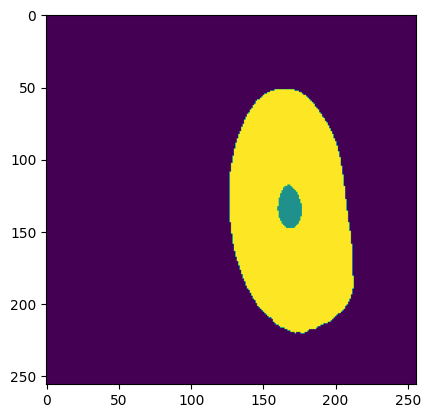

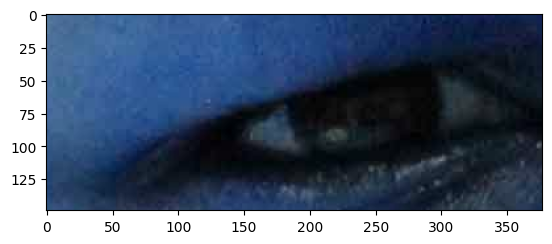

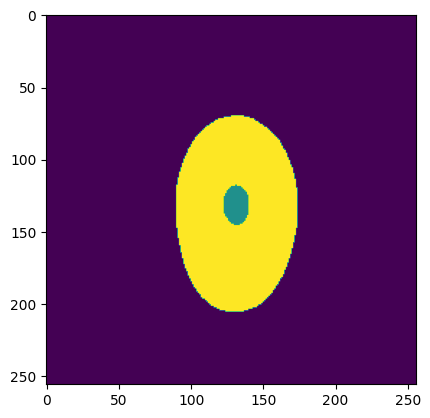

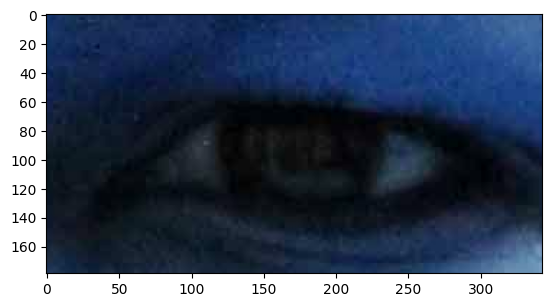

Right Eye shape:- (179, 343, 3)
Left Eye shape:- (149, 377, 3)


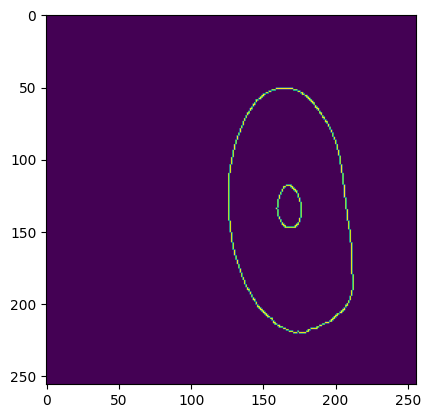

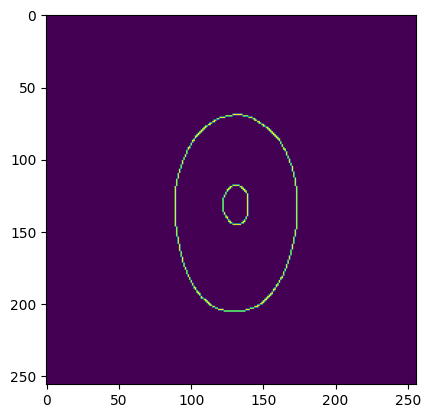

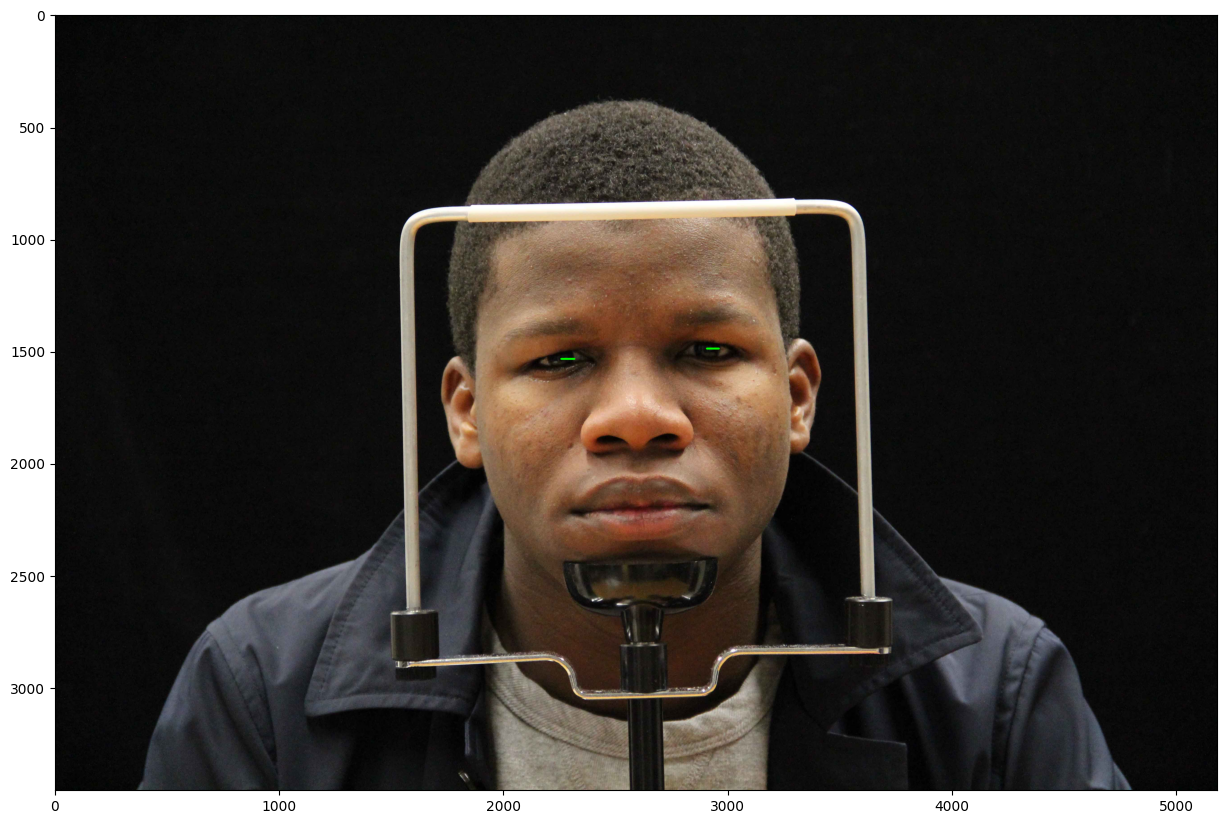

Left Eye Radius: 122.92081567796609
Right Eye Radius: 113.21994173728812


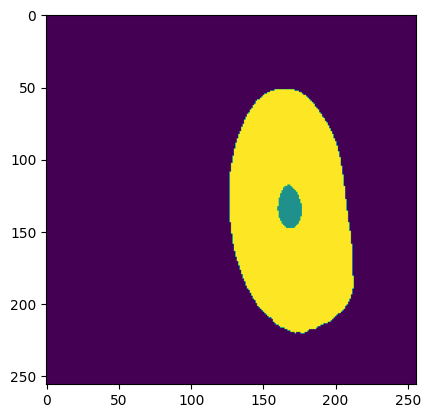

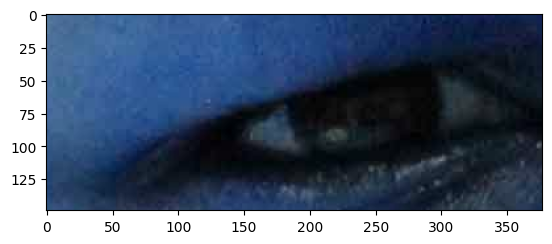

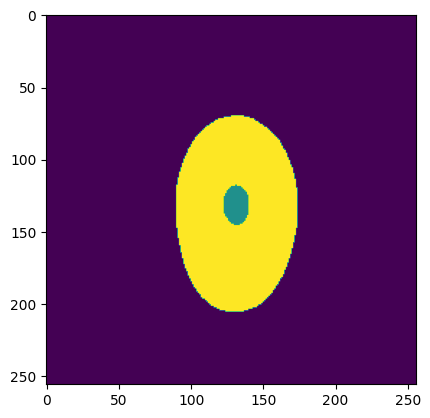

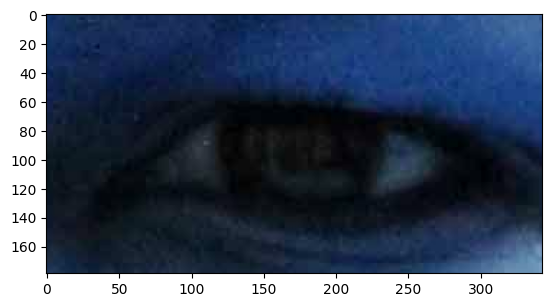

Right Eye shape:- (179, 343, 3)
Left Eye shape:- (149, 377, 3)


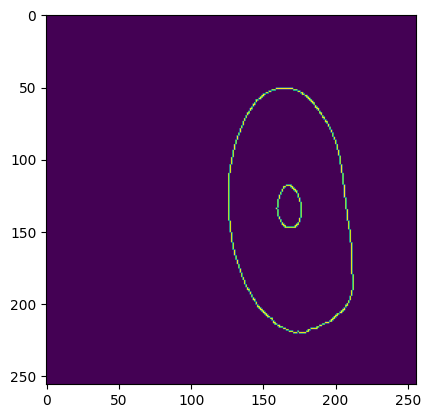

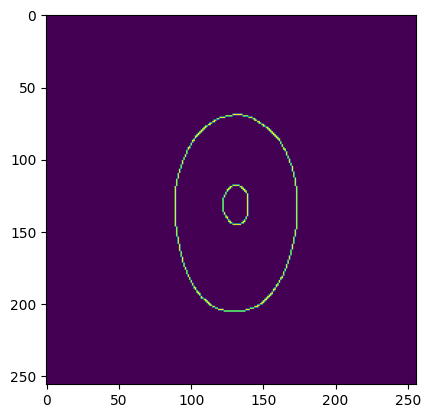

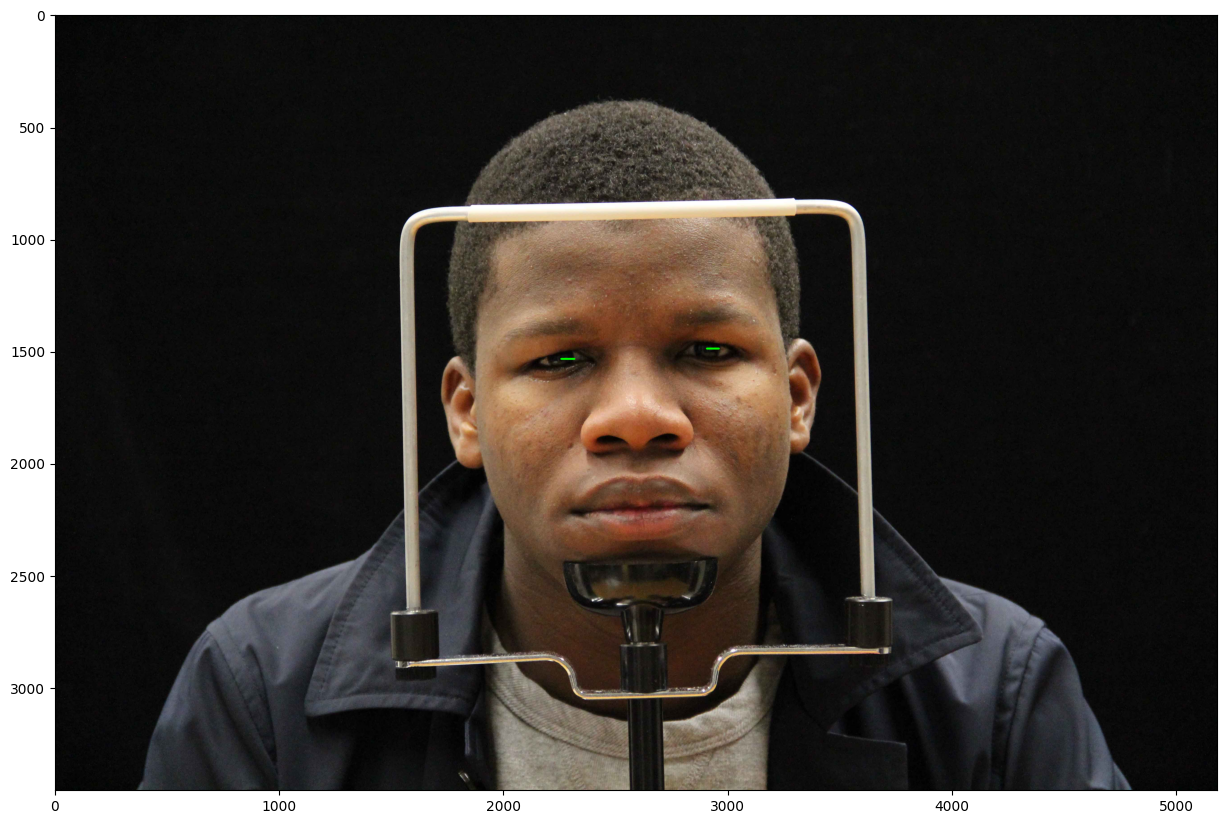

Left Eye Radius: 122.92081567796609
Right Eye Radius: 113.21994173728812


In [174]:
count = 0

while count <= 1:
    imgFilePath = os.path.join(image_path, firstImage)
    img = cv2.imread(imgFilePath)
    meanWidth, symmAxis_x, piyot_y, R, l_rad_iris, l_cx, l_cy, r_rad_iris, r_cx, r_cy,EyeCornerArray = initialization_function(
        img,count)
    
    # print()
    count += 1


In [175]:

def spheroProcessing(frame,
                     shape_array,
                     img_path ,
                     frameCounter,
                     theta,
                     GT_ANGLES,
                     symmAxis_x=symmAxis_x,
                     piyot_y=piyot_y,
                     R=R,
                     lEyeBallRadius=l_rad_iris,
                     rEyeBallRadius=r_rad_iris,
                     lCenterX=l_cx, lCenterY=l_cy,
                     rCenterX=r_cx, rCenterY=r_cy,
                     eyeCornerArray=EyeCornerArray
                     ):
    """_return Eye Gaze direction for Both Eye_

    Args:
        frame (_cv2.image_): _BGR Image_
        frameCounter (_int_): _current number of processed image_
        theta (_float_): _theta which obtained from GT_
        GT_ANGLES (_list_): _Ground Truth Eye Gaze Direction_
        symmAxis_x (_float_, optional): _Symmetric X axis_. Defaults to symmAxis_x.
        piyot_y (_float_, optional): _Piyot Y_. Defaults to piyot_y.
        R (_float_, optional): _MeanWidth/2_. Defaults to R.
        lEyeBallRadius (_float_, optional): _Radius of Left Eye Ball_. Defaults to l_rad_iris.
        rEyeBallRadius (_float_, optional): _Radius of Right Eye Ball_. Defaults to r_rad_iris.
        lCenterX (_float_, optional): _Left Iris Center X_. Defaults to l_cx.
        lCenterY (_float_, optional): _Left Iris Center Y_. Defaults to l_cy.
        rCenterX (_float_, optional): _Right Iris Center X_. Defaults to r_cx.
        rCenterY (_float_, optional): _Right Iris Center Y_. Defaults to r_cy.
        eyeCornerArray (_list_, optional): _Eye Corners In Initialiazation Stage_. Defaults to EyeCornerArray.
    """
    


    # MediaPiper Landmarks Array
    
    
    left_theta,right_theta = calCThetaAngle(imgFilePath,shape_array)
    
   

    left_eye, right_eye, Leye, Reye = cropped_image(
        frame, shape_array, enhance=False)

    # pred_c_leye = regressionPrediction(REGRESSION_MODEL, left_eye, mean=(
    #     0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    # pred_c_reye = regressionPrediction(REGRESSION_MODEL, right_eye, mean=(
    #     0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    # pred_l_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
    #     pred_c_leye, Leye)
    # pred_r_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
    #     pred_c_reye, Reye)
    
    pred_l_eye, pred_r_eye = predict_image_masku2net(
        model_U, left_eye), predict_image_masku2net(model_U, right_eye)
    
    plt.imshow(pred_l_eye)
    plt.show()
    plt.imshow(pred_r_eye)
    plt.show()
    
    # Iris Center and Radius Estimation by Segmented Mask & Image Moments
    l_rad_iris, l_cx, l_cy, rl_iris = findRadiusIrisImageMoments(
        pred_mask=pred_l_eye, eye_w=left_eye.shape[1], eye_h=left_eye.shape[0], margin=Leye)
    r_rad_iris, r_cx, r_cy, rr_iris = findRadiusIrisImageMoments(
        pred_mask=pred_r_eye, eye_w=right_eye.shape[1], eye_h=right_eye.shape[0], margin=Reye)
    
    pred_l_eye_toOriginaImage =[l_cx, l_cy]
    pred_r_eye_toOriginaImage = [r_cx, r_cy]
    
    # print(pred_l_eye_toOriginaImage)
    # print(pred_r_eye_toOriginaImage)

    cv2.circle(frame, (int(pred_l_eye_toOriginaImage[0]), int(
        pred_l_eye_toOriginaImage[1])), 3, (0, 255, 0), -1)

    cv2.circle(frame, (int(pred_r_eye_toOriginaImage[0]), int(
        pred_r_eye_toOriginaImage[1])), 3, (0, 255, 0), -1)

    plt.figure(figsize=(15, 15))
    plt.imshow(frame[:, :, ::-1])
    plt.show()

    # r = hpe.compute_rotation(shape_array)

    # theta, phi, roll, yaw_deg, pitch_deg, roll_deg = hpe.compute_angles(r, frameCounter)

    phi = 0
    theta = np.radians(theta)

    # print(f"Phi {phi}")

    # print(f"Roll {roll}")

    innerEyeCornerRot_right_x, innerEyeCornerRot_right_y, innerEyeCornerRot_left_x, innerEyeCornerRot_left_y = innerEyeCornerRotation(
        symmAxis_x, piyot_y, R, theta, phi, eyeCornerArray)

    
    # Obtaining the Eye Corner Location for the current frame
    innerEyeCorner_right_x, innerEyeCorner_right_y, outerEyeCorner_right_x, outerEyeCorner_right_y, innerEyeCorner_left_x, innerEyeCorner_left_y, outerEyeCorner_left_x, outerEyeCorner_left_y = innerOuterCornerofEye(
        shape_array)

    # Rotation for the Right Iris
    # Note:- Eye corners which are detected in the initialization phase are used in here
    irisRot_right_x, irisRot_right_y = gettingRotation(innerEyeX=eyeCornerArray[0],
                                                       innerEyey=eyeCornerArray[1],
                                                       outerEyex=eyeCornerArray[2],
                                                       outerEyey=eyeCornerArray[3],
                                                       symmAxis_x=symmAxis_x,
                                                       piyot_y=piyot_y,
                                                       radiusEyeBall=rEyeBallRadius,
                                                       irisCenterX=rCenterX,
                                                       irisCentery=rCenterY,
                                                       theta=theta,
                                                       phi=phi,
                                                       R=R)

    
    # Rotation for the Left Iris
    irisRot_left_x, irisRot_left_y = gettingRotation(innerEyeX=eyeCornerArray[4],
                                                     innerEyey=eyeCornerArray[5],
                                                     outerEyex=eyeCornerArray[6],
                                                     outerEyey=eyeCornerArray[7],
                                                     symmAxis_x=symmAxis_x,
                                                     piyot_y=piyot_y,
                                                     radiusEyeBall=lEyeBallRadius,
                                                     irisCenterX=lCenterX,
                                                     irisCentery=lCenterY,
                                                     theta=theta,
                                                     phi=phi,
                                                     R=R)

    alpha_right, beta_right = eyeGazeDirectionRight(currentIrisCenterX=pred_r_eye_toOriginaImage[0],
                                                    currentIrisCenterY=pred_r_eye_toOriginaImage[1],
                                                    innerEyecornerX=innerEyeCorner_right_x,
                                                    innerEyecornerY=innerEyeCorner_right_y,
                                                    irisRotX=irisRot_right_x,
                                                    irisRotY=irisRot_right_y,
                                                    innerEyeCornerRotX=innerEyeCornerRot_right_x,
                                                    innerEyeCornerRotY=innerEyeCornerRot_right_y,
                                                    radiusEyeBall=rEyeBallRadius,
                                                    theta=theta,
                                                    phi=phi)

    alpha_left, beta_left = eyeGazeDirectionLeft(currentIrisCenterX=pred_l_eye_toOriginaImage[0],
                                                 currentIrisCenterY=pred_l_eye_toOriginaImage[1],
                                                 innerEyecornerX=innerEyeCorner_left_x,
                                                 innerEyecornerY=innerEyeCorner_left_y,
                                                 irisRotX=irisRot_left_x,
                                                 irisRotY=irisRot_left_y,
                                                 innerEyeCornerRotX=innerEyeCornerRot_left_x,
                                                 innerEyeCornerRotY=innerEyeCornerRot_left_y,
                                                 radiusEyeBall=lEyeBallRadius,
                                                 theta=theta,
                                                 phi=phi)

    
    print(
        f"Alpha Right :- {np.degrees(alpha_right)}  | Beta Right {np.degrees(beta_right)}")
    print(
        f"Alpha Left :- {np.degrees(alpha_left)}  | Beta Left {np.degrees(beta_left)}")
    
    abs_leftAlpha = abs(abs(np.degrees(alpha_left)) - left_theta) 
    
    abs_rightAlpha = abs(abs(np.degrees(alpha_right)) - right_theta) 
    
    
    abs_leftBeta = abs(abs(np.degrees(beta_left)) - GT_ANGLES[-2]) 
    
    abs_rightBeta = abs(abs(np.degrees(beta_right)) - GT_ANGLES[-2]) 
    
    
    
    
    
    print(f"GT alpha {GT_ANGLES[-1]} | GT beta {GT_ANGLES[-2]}")
    print()
    print(f"Updated GT right Theta:- {right_theta}")
    print(f"Updated GT left Theta :- {left_theta}")
    print("*"*10)

    return abs_leftAlpha,abs_rightAlpha,abs_leftBeta,abs_rightBeta


In [154]:
# For Initialization Check
# for z, f_name in enumerate(testing_stage):

#     imgFilePath = os.path.join(image_path, f_name)

#     img = cv2.imread(imgFilePath)

#     print(imgFilePath)
#     meanWidth, symmAxis_x, piyot_y, R, l_rad_iris, l_cx, l_cy, r_rad_iris, r_cx, r_cy = initialization_function(
#         img, z)

    # if z == 2:
    #     break


In [176]:
EyeCornerArray

(2780, 1530, 3074, 1515, 2388, 1555, 2087, 1576)

In [177]:
testing_stage

['0042_2m_0P_-10V_-15H.jpg',
 '0042_2m_15P_0V_0H.jpg',
 '0042_2m_15P_0V_5H.jpg',
 '0042_2m_15P_0V_10H.jpg',
 '0042_2m_15P_0V_15H.jpg',
 '0042_2m_15P_0V_-5H.jpg',
 '0042_2m_15P_0V_-10H.jpg',
 '0042_2m_15P_0V_-15H.jpg',
 '0042_2m_15P_10V_0H.jpg',
 '0042_2m_15P_10V_5H.jpg',
 '0042_2m_15P_10V_10H.jpg',
 '0042_2m_15P_10V_15H.jpg',
 '0042_2m_15P_10V_-5H.jpg',
 '0042_2m_15P_10V_-10H.jpg',
 '0042_2m_15P_10V_-15H.jpg',
 '0042_2m_15P_-10V_0H.jpg',
 '0042_2m_15P_-10V_5H.jpg',
 '0042_2m_15P_-10V_10H.jpg',
 '0042_2m_15P_-10V_15H.jpg',
 '0042_2m_15P_-10V_-5H.jpg',
 '0042_2m_15P_-10V_-10H.jpg',
 '0042_2m_15P_-10V_-15H.jpg',
 '0042_2m_30P_0V_0H.jpg',
 '0042_2m_30P_0V_5H.jpg',
 '0042_2m_30P_0V_10H.jpg',
 '0042_2m_30P_0V_15H.jpg',
 '0042_2m_30P_0V_-5H.jpg',
 '0042_2m_30P_0V_-10H.jpg',
 '0042_2m_30P_0V_-15H.jpg',
 '0042_2m_30P_10V_0H.jpg',
 '0042_2m_30P_10V_5H.jpg',
 '0042_2m_30P_10V_10H.jpg',
 '0042_2m_30P_10V_15H.jpg',
 '0042_2m_30P_10V_-5H.jpg',
 '0042_2m_30P_10V_-10H.jpg',
 '0042_2m_30P_10V_-15H.jpg'

In [178]:
def captureFaceLandmarks(frame):

    results = face_mesh.process(frame)
    
    if results.multi_face_landmarks is not None:
        landmarks = results.multi_face_landmarks[0]

        shape_arr = []

        for landmark in landmarks.landmark:

            x = landmark.x
            y = landmark.y

            relative_x = int(x * frame.shape[1])
            relative_y = int(y * frame.shape[0])

            shape_arr.append([relative_x, relative_y])

        return np.array(shape_arr)
    else:
        return []

In [179]:
def filterHeadPoseImages(image_array):
    
    filterd_array = []
    for image_name in image_array:
        
        if image_name.split("_")[2] == "0P":
            filterd_array.append(image_name)
            
    return filterd_array

In [180]:
testing_filtered_images = filterHeadPoseImages(initialization_images)

In [181]:
testing_filtered_images

['0042_2m_0P_0V_0H.jpg',
 '0042_2m_0P_0V_5H.jpg',
 '0042_2m_0P_0V_10H.jpg',
 '0042_2m_0P_0V_15H.jpg',
 '0042_2m_0P_0V_-5H.jpg',
 '0042_2m_0P_0V_-10H.jpg',
 '0042_2m_0P_0V_-15H.jpg',
 '0042_2m_0P_10V_0H.jpg',
 '0042_2m_0P_10V_5H.jpg',
 '0042_2m_0P_10V_10H.jpg',
 '0042_2m_0P_10V_15H.jpg',
 '0042_2m_0P_10V_-5H.jpg',
 '0042_2m_0P_10V_-10H.jpg',
 '0042_2m_0P_10V_-15H.jpg',
 '0042_2m_0P_-10V_0H.jpg',
 '0042_2m_0P_-10V_5H.jpg',
 '0042_2m_0P_-10V_10H.jpg',
 '0042_2m_0P_-10V_15H.jpg',
 '0042_2m_0P_-10V_-5H.jpg',
 '0042_2m_0P_-10V_-10H.jpg']

0042_2m_0P_0V_0H.jpg
468


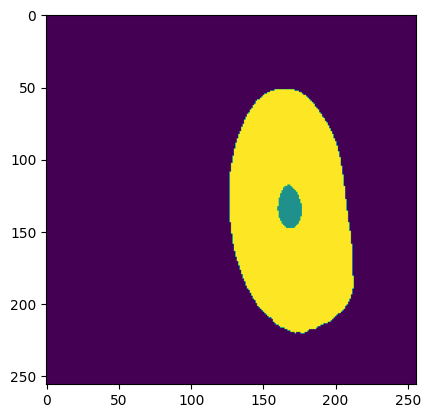

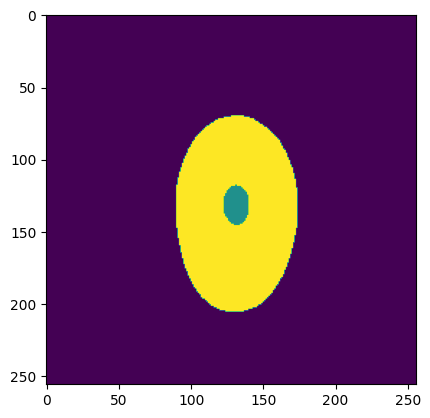

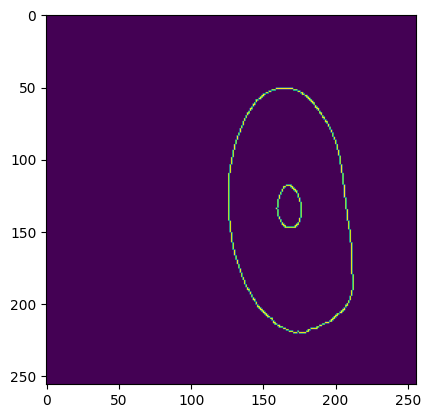

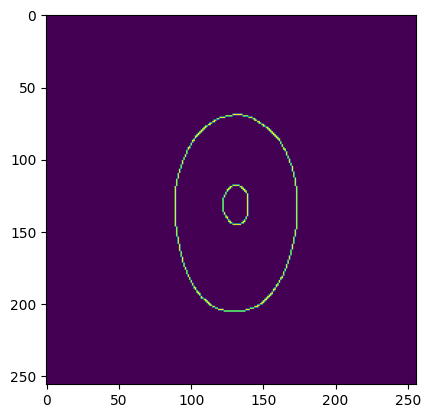

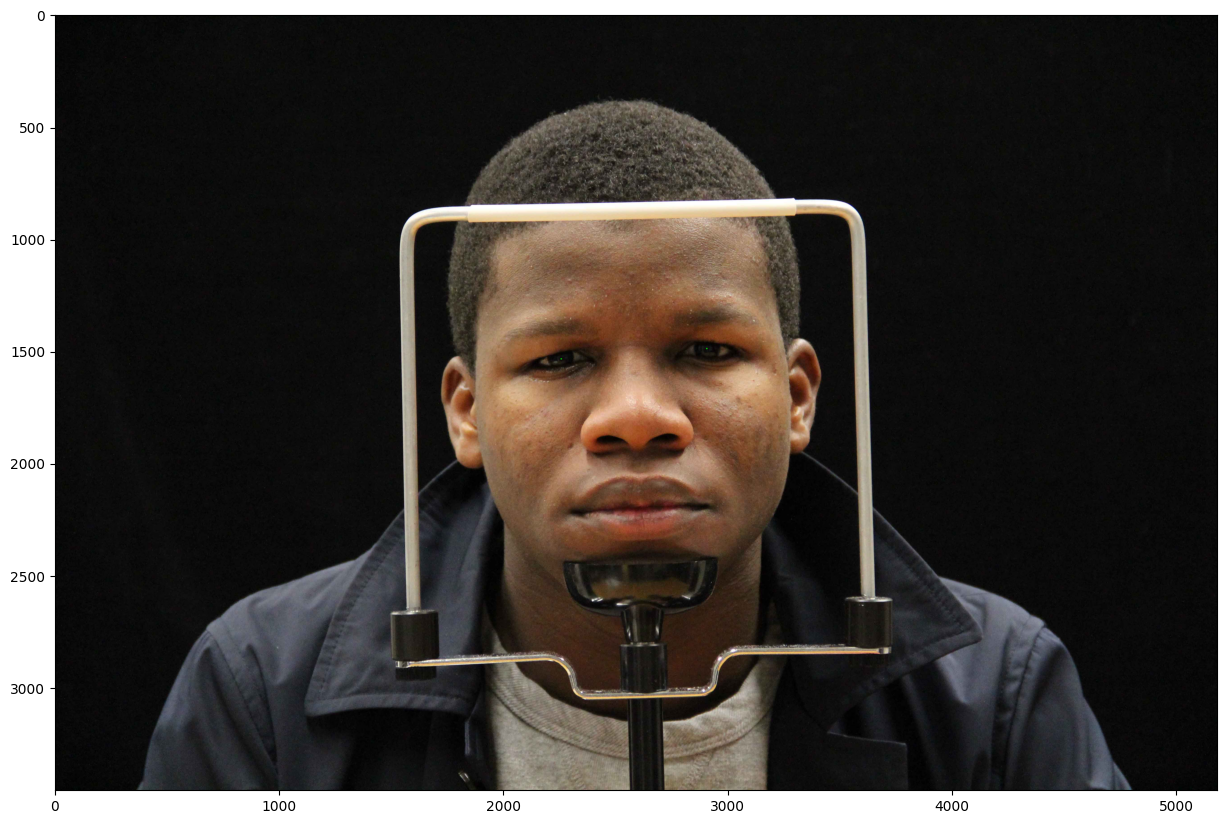

Alpha Right :- 0.0  | Beta Right 0.0
Alpha Left :- 0.0  | Beta Left 0.0
GT alpha 0.0 | GT beta 0.0

Updated GT right Theta:- 0.39981926534801254
Updated GT left Theta :- 0.4044817266676382
**********
0042_2m_0P_0V_5H.jpg
468


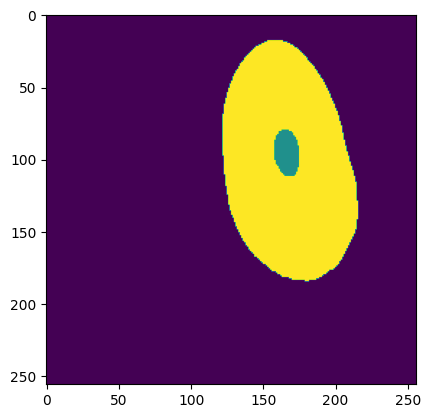

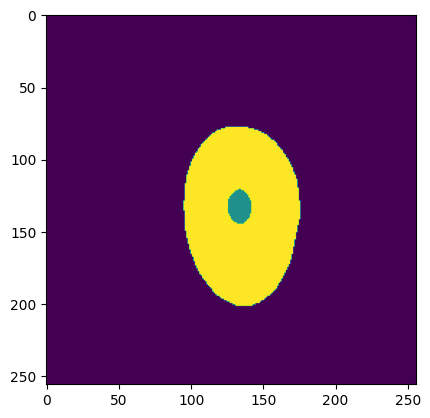

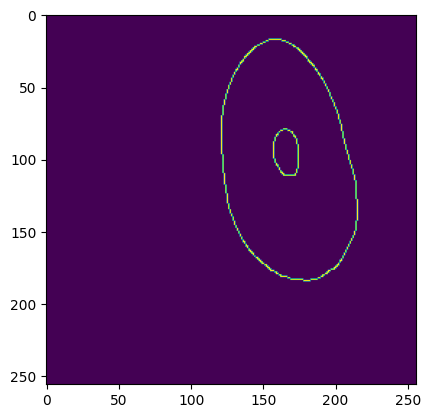

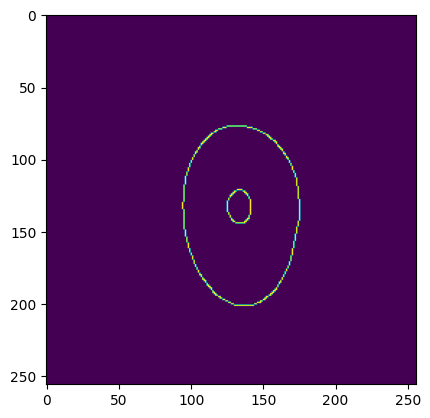

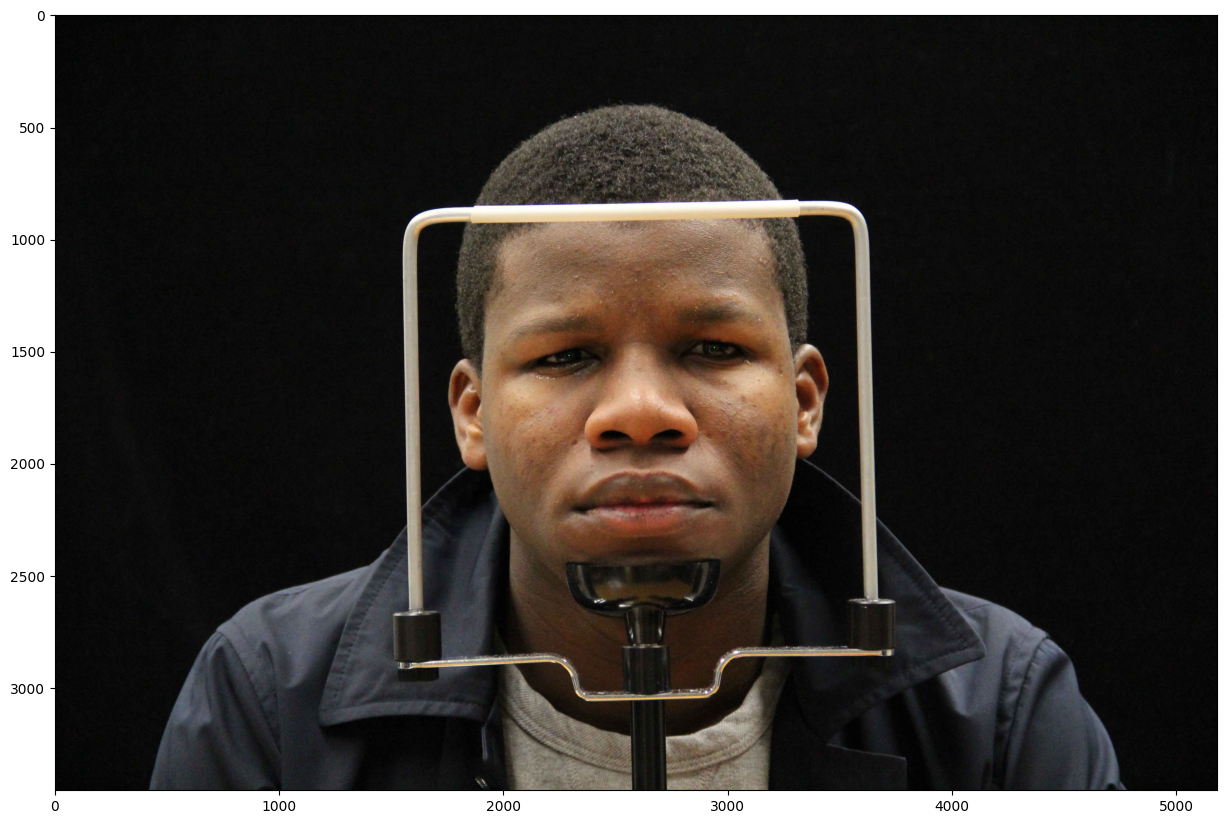

Alpha Right :- 2.024650586799739  | Beta Right 1.0121672709138012
Alpha Left :- 0.9322799807058123  | Beta Left 7.949510591454508
GT alpha 5.0 | GT beta 0.0

Updated GT right Theta:- 4.601325816106671
Updated GT left Theta :- 5.394894676427903
**********
0042_2m_0P_0V_10H.jpg
468


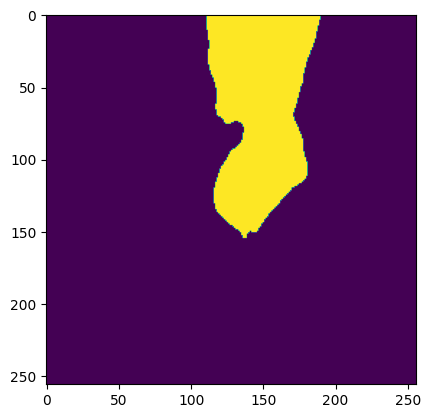

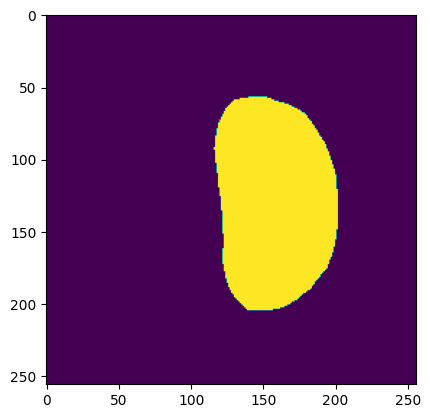

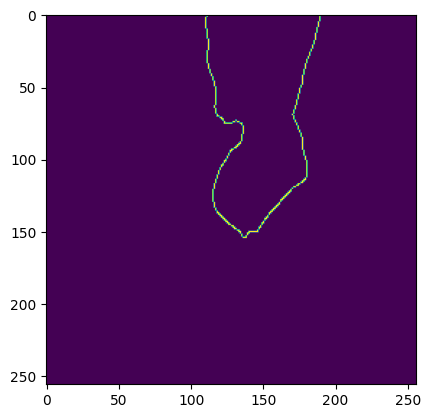

IndexError: list index out of range

In [182]:
#For Initialization Check

leftAlpha = []
rightAlpha = []

leftBeta = []
rightBeta = []



for z, f_name in enumerate(testing_filtered_images):

    
    print(f_name)
    
    
    imgFilePath = os.path.join(image_path, f_name)

    img= cv2.imread(imgFilePath)
    
    shape_array = captureFaceLandmarks(img)
    
    print(len(shape_array))
    if len(shape_array) ==0 :
        print("MediaPipe Failed to Detect the Face")
        continue
    else:
        
        
        #Get Theta Angle from GT image Name
        theta = float(f_name.split("_")[2][:-1])
        
        # Get angles for alpha & beta 
        gtAngles = [float(angle[:-1]) for angle in f_name.split(".")[0].split("_")[2:]]
        abs_leftAlpha,abs_rightAlpha,abs_leftBeta,abs_rightBeta = spheroProcessing(img,shape_array,img_path = imgFilePath, frameCounter=z,theta=theta,GT_ANGLES=gtAngles)
        
        leftAlpha.append(abs_leftAlpha)
        rightAlpha.append(abs_rightAlpha)
        
        leftBeta.append(abs_leftBeta)
        rightBeta.append(abs_rightBeta)
    
        
    # if z == 2:
    #     break

In [162]:
leftAlpha = np.array(leftAlpha)
rightAlpha = np.array(rightAlpha)
leftBeta=np.array(leftBeta)
rightBeta = np.array(rightBeta)


In [163]:
# Yaw --> Alpha
# Pitch --> Beta


# Average over the subjects values and get the mean of MAE and SD

In [164]:
meanLeftAlpha = np.mean(leftAlpha)
stdLeftAlpha = np.std(leftAlpha)

print(meanLeftAlpha)
print(stdLeftAlpha)



3.4482972764453477
2.6562226741428447


In [165]:
meanRightAlpha = np.mean(rightAlpha )
stdRightAlpha = np.std(rightAlpha)

print(meanRightAlpha)
print(stdRightAlpha)

4.061557463031931
3.2033417776398343


In [166]:
meanLeftBeta= np.mean(leftBeta)
stdLeftBeta = np.std(leftBeta)

print(meanLeftBeta)
print(stdLeftBeta)

6.8124184833562484
6.7625832899573055


In [167]:
meanRightBeta= np.mean(rightBeta )
stdRightBeta = np.std(rightBeta)


print(meanRightBeta)
print(stdRightBeta)

7.474774742979328
3.9915298456058794


In [ ]:
# def innnerOuterEyeCorners(landmarks):
    

In [ ]:
def findRadiusComponentAnalysis(pred)

In [ ]:
image_path = "/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/AllDatasetMix/images/008_10_right.png"


In [ ]:
image = cv2.imread(image_path)


image.shape


In [ ]:
pred = regressionPrediction(REGRESSION_MODEL, image, mean=(
    0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


In [ ]:
# pred_eye = rescale_coordinate(pred,image,RESIZE_AMT_REGRESSION)


In [ ]:
cv2.circle(image, (int(pred[0]), int(pred[1])), 1, (0, 255, 0), -1)


In [ ]:
plt.imshow(image[:, :, ::-1])


In [ ]:
pred


In [ ]:
# x = "0009_2m_0P_-10V_-15H.jpg"

In [ ]:
# [float(angle[:-1]) for angle in x.split(".")[0].split("_")[2:]]